<a href="https://colab.research.google.com/github/JDS289/-DNNs/blob/main/tempE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning and Neural Networks Second Assignment 2024
### Ferenc Huszár and Nic Lane
#### due date: Friday, 21 March 2025, 12:00 PM

##Information

Welcome to the second assignment for the Deep Neural Networks module. In this assignment you will explore some of the model architectures we talked about in the second half of lectures (ConvNets, Transformers) and you will also implement a fun model called MLP Mixer.

There are 70 marks given in total for this second assessment ($70\%$ of the total of 100 marks for the course), broken into three sections:
* (D) 10 marks for the ConvNet exercise
* (E) 20 marks for the Transformer/MLP Mixer exercise
* (F) 40 marks for a mini-project of your choice

#### Compute Resources: Kaggle Notebooks

Since this Assignment benefits from GPU acceleration, we recommend using the [kaggle notebook](https://www.kaggle.com/docs/notebooks) platform. Kaggle notebooks are similar to google colab, but offer a more predictable 30 hours/week quota on their GPUs for free. This is plenty of GPU time to get the assignment done, you shouldn't need any more.

However, use your GPU quota sparingly, for example switch to a non-GPU instance unless you are working on tasks that need a GPU, and terminate your session once you're not working on it. To enable GPUs and Internet access, you need to verify your phone number on your kaggle account. This can be selected in the Notebook options section of the panel to the right of the actual notebook. Please talk to us if any issues arise.

#### Mini-projects

Mini-project tasks are a more exploratory and open-ended, giving you an opportunity to decide which aspect you'd like to focus on. The idea is to introduce you to the form of assess\ment typical in our Part III/MPhil modules. Mini-projects come with instructions, to indicate the depth of work we expect for certain marks, but you should feel free to deviate from instructions if you have a better idea to explore within the context. There are two options, one with a more theory/maths focus, one with more of an engineering focus.

As a guide, when marking we will take into account three factors:

* **extent of work:** did you do the expected amount of work (you won't get extra marks by doing a lot more than others, this is not a race). We will try to give an indication of this in the module description.
* **correctness/technical understanding:** is your solution and description of findings technincally correct, does it demonstrate learning and understanding of the topics we cover, and an ability to do independent reading if needed?
* **presentation:** How is the mini-project written up? Please focus on the writeup being short, to the point, well structured. Are figures well formatted, so it's clear what's shown on them (e.g. are there axis labels)?

You can choose whichever project you want to attempt. You can attempt more than one, but we will only mark one. **Please clearly state which of the mini-projects you would like us to mark**, if this is unclear, we will mark whichever appears fist in your submitted notebook.

# E: Transformer vs MLP Mixer on Modular Arithmetic
_[20 marks] 2 page writeup + appendices_

##Info

In this part of the assignment, you will train models to perform modular addition of integers A bit more formally, the model has to learn to predict elements of the Cayley table (multiplication table) of the *97-element cyclic group*.

If we represent integers as integers, the problem becomes very easy, as models built on linear algebra operations already "know" how to add numbers. Instead, we will pretend we don't know that the group is isomorphic to integers, and we will encode the 97 elements of the group as arbitrarily chosen tokens. This way, the model will have to build a useful representation of group elements.

Mathematically, we consider the following dataset:

* token alphabet $\Sigma$ of size $97$
* a bijective map $\pi: \Sigma \mapsto \mathbb{Z}_{97}$, where $\mathbb{Z}_{97} = \{0, 1, \ldots, 96\}$
* a dataset consisting of pairs of inputs $x = [x_1, x_2] \in \Sigma^2$ and labels $y \in \Sigma$ such that:

$$
\pi(x_1) + \pi(x_2) \equiv \pi (y)\ \ (\operatorname{mod} 97)
$$

For simplicity, we can choose the alphabet $\Sigma$ to be $\mathbb{Z}_{97}$ in which case $\pi$ becomes a permutation.

Note that there are $97\times 97 = 9409$ unique possible datapoints, forming the Cayley table (multiplication table) for the 97-element cyclic group.

Your models will have to learn to predict $y$ from $x$, given only a fraction of all pairs as training data. For example:

![](https://i.imgur.com/SfwC4Jy.png)

The figure depicts the Cayley table for the 5-element cyclic group over a chosen alphabet $\Sigma = {a,b,c,d,e}$. There are 25 entries, corresponding to 25 possible datapoints. We will sample 18 of these as training data, while 7 (shown in grey) are held out as test data. We fit our model to the entries in the training data (for example the pair $x = [a, b], y = b$) and evaluate the model's accuracy in predicting the held-out entries.


## E.1: Creating a dataset



Implement a dataset for the task above:
* make it a subclass of the pytorch `TensorDataset`. This will make it easy to move the entire dataset to the GPU.
* the dataset should implement an invertible mapping $\pi$ from a token alphabet $\sigma$ to integers $\mathbb{Z}_{97}$ - consider using `random.shuffle` with a fixed random seed.
* the dataset should contain all entries of the multiplication table exactly once.
* test your implementation with assertions about the total number of datapoints, the total number of each token appearing in different positions in the dataset, etc.

In [2]:
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from torch import nn
from torch.nn import functional as F
import random


class Mod97Dataset(TensorDataset):
    def __init__(self, alphabet):
        assert len(set(alphabet)) == 97
        random.shuffle(alphabet)
        self.alphabet = alphabet

        self.mapping_dict = {}
        self.mapping_inverse_dict = {}
        for integer, token in enumerate(self.alphabet):
            self.mapping_dict[token] = integer
            self.mapping_inverse_dict[integer] = token

        inputs = []
        outputs = []
        for t1 in self.alphabet:
            for t2 in self.alphabet[self.alphabet.index(t1):]:  # to avoid repeats (commutative, so redundant)
                inputs.append([t1, t2])
                outputs.append(self.unmap((self.map(t1)+self.map(t2)) % 97))

        self.tensors = (torch.tensor(inputs), torch.tensor(outputs))   # self.tensors is used by parent class
        assert len(self.tensors[0]) == len(self.tensors[1]) == (97*96)/2 + 97  # 97C2 of {x, y}, and 97 of (z, z)

    def map(self, token):
        return self.mapping_dict[token]

    def unmap(self, integer):
        return self.mapping_inverse_dict[integer]

    def cuda(self):
        self.tensors = (self.tensors[0].cuda(), self.tensors[1].cuda())
        return self

## E.2: Implement a Transformer



Now, let's build a small, shallow transformer, using components from the pytorch neural network libraries.

First, take some time thinking about model requirements:
1. Decide whether you want a decoder-only, encoder-only or encoder-decoder transformer for this task.
1. Decide whether you need position embeddings.
1. Remember that autoregressive transformer language models use causal attention masks. Does your model need this, if so, where?
1. Since the label you predict is discrete, you have to choose the loss function that reflects this.


Then implement a model. You may use pre-existing layers or building blocks, for example [TransformerEncoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html). Please don't simply import or copy a complete model used someplace else. Nor do you have to implement attention from ground up. Finally, your implemented Transformer model on a set percentage of the modular addition data.


Hints:
* A decoder-only transfomer is composed of token and position embeddings as the first operation, these are followed by causal transformer layer.
* By causal masking I referred to the Masked Self-Attention layer (with a triangular mask so each token only aggregates information from the past but not the future). Pytorch provides masking functionality via an argument to the `forward` method.
* The original Transformer used layer normalization after the other operations, later it's been observed that it's better to normalize before the operations. Torch provides a flag to make this change.
* Don't forget the token embedding layer as the first operation of the transformer.
* This problem was chosen because a relatively small Transformer model can be trained successfully. You should see that using $50-70\%$ of the dataset as training should yield very good test accuracy.
* This task was inspired by the [paper on grokking](https://arxiv.org/abs/2201.02177), whose results suggest that a small transformer, trained with AdamW and weight decay would perform well, and these results are widely reproduced.

In [4]:
class ModularAdditionTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        transformer_layer = nn.TransformerEncoderLayer(embed_dim, num_heads, norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers, enable_nested_tensor=False)
        self.linear = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.transformer_encoder(self.embedding(x).transpose(0, 1))
        return self.linear(x.mean(dim=0))

In [11]:
def random_batch_split(num_batches, train): # random_split can take [0.1]*10, but seems to fail for [0.05]*20, so here's a workaround
    if num_batches <= 10:
        batch_list = num_batches * [1/num_batches]
    else:
        batch_list = num_batches * [len(train)//num_batches]
        num_remaining = len(train) - sum(batch_list)
        for i in range(num_remaining):
            batch_list[i] += 1
    return random_split(train, batch_list)


def format_losses(epoch, training_loss, test_loss):
    return f"\tEpoch {epoch:>5}:   "  \
         + f"Training Loss: {training_loss:.4f},  Test Loss: {test_loss:.4f}"


def train_model(model, dataset, train_split, num_epochs, learning_rate, num_batches=5, weight_decay=0.05, betas=(0.9, 0.999)):
    train, test = random_split(dataset, [train_split, 1-train_split])
    test_inputs, test_labels = test[::]
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=betas)
    loss_fn = nn.CrossEntropyLoss()
    model.eval()

    print(f"With {round(train_split*100)}% of data for training; learning_rate={learning_rate}")
    with torch.no_grad():
        initial_training_loss = loss_fn(model(train[::][0]), train[::][1])
        initial_test_loss = loss_fn(model(test_inputs), test_labels)
    test_losses.append([(0, initial_test_loss.item())])
    print(format_losses(0, initial_training_loss, initial_test_loss))

    model.train()
    for epoch in range(1, num_epochs+1):
        optimizer.zero_grad()
        for batch in random_batch_split(num_batches, train):
            input_batch, label_batch = batch[::]
            training_loss = loss_fn(model(input_batch), label_batch)
            training_loss.backward()
            optimizer.step()

        if 5*epoch//num_epochs > 5*(epoch-1)//num_epochs:
            model.eval()
            with torch.no_grad():
                avg_training_loss, test_loss = loss_fn(model(train[::][0]), train[::][1]), loss_fn(model(test_inputs), test_labels)
            test_losses[-1].append((epoch, test_loss.item()))
            print(format_losses(epoch, avg_training_loss, test_loss))
            model.train()

    model.eval()
    with torch.no_grad():
        probs = F.softmax(model(test_inputs), dim=-1)
        predicted = probs.argmax(dim=-1)
        accuracy = (predicted==test_labels).float().mean().item()
        print('\tAccuracy of "best-guess"es on the test set:"', f"{accuracy*100:.2f}%", "\n\n")

In [22]:
dataset = Mod97Dataset(list(range(97))).cuda()

test_losses = []

model = ModularAdditionTransformer(97, embed_dim=16, num_heads=4, num_layers=1).cuda()
train_model(model, dataset, train_split=0.9, num_epochs=400, learning_rate=0.0015, betas=(0.95, 0.999))

model = ModularAdditionTransformer(97, embed_dim=16, num_heads=4, num_layers=2).cuda()
train_model(model, dataset, train_split=0.7, num_epochs=600, learning_rate=0.001, weight_decay=0.1, betas=(0.95, 0.999))

model = ModularAdditionTransformer(97, embed_dim=16, num_heads=4, num_layers=2).cuda()
train_model(model, dataset, train_split=0.5, num_epochs=1000, learning_rate=0.002, weight_decay=0.4, betas=(0.95, 0.999))

model = ModularAdditionTransformer(97, embed_dim=16, num_heads=4, num_layers=2).cuda()
train_model(model, dataset, train_split=0.3, num_batches=10, num_epochs=1000, learning_rate=0.0009, weight_decay=0.9, betas=(0.95, 0.999))


transformer_test_losses = list(zip((0.9, 0.7, 0.5, 0.3), test_losses))

With 90% of data for training; learning_rate=0.0015
	Epoch     0:   Training Loss: 4.6863,  Test Loss: 4.7142
	Epoch    80:   Training Loss: 4.1490,  Test Loss: 4.9755
	Epoch   160:   Training Loss: 0.9626,  Test Loss: 1.1483
	Epoch   240:   Training Loss: 0.1683,  Test Loss: 0.1994
	Epoch   320:   Training Loss: 0.0414,  Test Loss: 0.0481
	Epoch   400:   Training Loss: 0.0110,  Test Loss: 0.0128
	Accuracy of "best-guess"es on the test set:" 100.00% 


With 70% of data for training; learning_rate=0.001
	Epoch     0:   Training Loss: 4.7687,  Test Loss: 4.7669
	Epoch   120:   Training Loss: 3.9304,  Test Loss: 5.3155
	Epoch   240:   Training Loss: 3.0419,  Test Loss: 5.8644
	Epoch   360:   Training Loss: 2.2905,  Test Loss: 5.7783
	Epoch   480:   Training Loss: 0.8162,  Test Loss: 1.8115
	Epoch   600:   Training Loss: 0.0205,  Test Loss: 0.0366
	Accuracy of "best-guess"es on the test set:" 100.00% 


With 50% of data for training; learning_rate=0.002
	Epoch     0:   Training Loss: 4.753

In [48]:
dataset = Mod97Dataset(list(range(97))).cuda()

test_losses = []

model = ModularAdditionTransformer(97, embed_dim=16, num_heads=4, num_layers=1).cuda()
train_model(model, dataset, train_split=0.9, num_epochs=400, learning_rate=0.0015)

model = ModularAdditionTransformer(97, embed_dim=16, num_heads=4, num_layers=2).cuda()
train_model(model, dataset, train_split=0.7, num_epochs=600, learning_rate=0.001, weight_decay=0.1)

model = ModularAdditionTransformer(97, embed_dim=16, num_heads=4, num_layers=2).cuda()
train_model(model, dataset, train_split=0.5, num_epochs=1000, learning_rate=0.0025, weight_decay=0.4)

model = ModularAdditionTransformer(97, embed_dim=16, num_heads=4, num_layers=2).cuda()
train_model(model, dataset, train_split=0.3, num_batches=10, num_epochs=1000, learning_rate=0.001, weight_decay=1.1)


transformer_test_losses = list(zip((0.9, 0.7, 0.5, 0.3), test_losses))

With 90% of data for training; learning_rate=0.0015
	Epoch     0:   Training Loss: 4.6798,  Test Loss: 4.6374
	Epoch    80:   Training Loss: 3.8289,  Test Loss: 4.4663
	Epoch   160:   Training Loss: 2.0023,  Test Loss: 2.3754
	Epoch   240:   Training Loss: 0.7706,  Test Loss: 0.8860
	Epoch   320:   Training Loss: 0.5246,  Test Loss: 0.6116
	Epoch   400:   Training Loss: 0.2543,  Test Loss: 0.2904
	Accuracy of "best-guess"es on the test set:" 100.00% 


With 70% of data for training; learning_rate=0.001
	Epoch     0:   Training Loss: 4.7025,  Test Loss: 4.7021
	Epoch   120:   Training Loss: 3.7761,  Test Loss: 4.7930
	Epoch   240:   Training Loss: 1.4432,  Test Loss: 1.7444
	Epoch   360:   Training Loss: 0.0422,  Test Loss: 0.0545
	Epoch   480:   Training Loss: 0.0074,  Test Loss: 0.0094
	Epoch   600:   Training Loss: 0.0033,  Test Loss: 0.0042
	Accuracy of "best-guess"es on the test set:" 100.00% 


With 50% of data for training; learning_rate=0.0025
	Epoch     0:   Training Loss: 4.70

In [39]:
model_load = ModularAdditionTransformer(97, embed_dim=16, num_heads=4, num_layers=1).cuda()

In [ ]:
#with open("/content/drive/MyDrive/DNNs2/transformer_test_losses.pkl", "rb") as f:
#    transformer_test_losses = pickle.load(f)

In [71]:
import pickle
#with open("/content/drive/MyDrive/DNNs2/transformer_test_losses.pkl", "wb") as f:
#    pickle.dump(transformer_test_losses, f)

## E.3: Implement an MLP Mixer



Here, we will implement the simple, and somewhat quirky model Neil Houlsby presented in his guest lecture: the [MLP Mixer](https://arxiv.org/abs/2105.01601). Although it might look complicated, it is easier to code from scratch than a Transformer as it uses standard layers.

The MLP mixer was inspired by encoder-only transformers, which have alternating blocks of multi-head self-attention and fully conected networks (MLPs). The attention layer communicates information across tokens, while the fully connected network processes each token in isolation, in parallel.

**MLPs are All you Need**

Below is a drawing of the MLP-mixer architecture. (the figure labels tokens as "patches" and embedding dimensions as "channels", owing to the fact that this architecture was introduced in a vision context)

![](https://mchromiak.github.io/articles/2021/May/05/MLP-Mixer/img/Mixer.png)

The MLP mixer model replaces multi-head attention with an MLP. As a starting point, like in a transformer, an embedding layer maps our input to a tensor of size `batchsize * sequence_length * embedding_dim`.

Then, it alternates two kinds of blocks:
* odd blocks apply an MLP across tokens, with input and output dimension `sequence_length` evaluated in parallel for every input in the batch and every embedding dimension.
* even blocks apply a MLP across embedding dimensions, with input and output dimension `embedding_dim`, evaluated in parallel for every datapoint in a batch and every input token.

Please implement your MLP Mixer architecture from scratch (i.e. using basic pytorch layers such as `Linear`, `ReLU`, `LayerNorm`, but please don't use a pre-defined MLP Mixer).

Notes:
* as you see, in the original architecture includes `LayerNorm` which speeds up training, as well as skip connections like in a ResNet which are especially important in deep versions.
* the pytorch [`Linear` layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is implemented in such a way that it always applies matrix multiplication to the last dimension of a tensor, and the operation is carried out in parallel for all other dimensions. This will come very handy here.
* The MLP mixer only works on a fixed size input sequence. Thus, it is nice for image processing, and it applies to our situation where the input is always two tokens long.
* Like Neil Suggested, to make these architectures work in the low data regime, regularisation is likely helpful. Weight decay combined with AdamW could be a good starting point.

In [31]:
class MixerBlock(nn.Module):
    def __init__(self, num_tokens, embed_dim, token_mlp_dim, channel_mlp_dim, dropout):
        super().__init__()
        self.token_mlp = nn.Sequential(
            nn.LayerNorm(num_tokens),
            nn.Linear(num_tokens, token_mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(token_mlp_dim, num_tokens)
        )

        self.channel_mlp = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, channel_mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(channel_mlp_dim, embed_dim)
        )

    def forward(self, x):
        y = self.token_mlp(x.transpose(1, 2)).transpose(1, 2)
        return x+y + self.channel_mlp(x+y)


class MLPMixer(nn.Module):
    def __init__(self, num_tokens, embed_dim, num_classes, num_layers, token_mlp_dim, channel_mlp_dim, dropout=0.1):
        super().__init__()
        self.token_embedding = nn.Embedding(num_classes, embed_dim)
        self.mixer_blocks = nn.ModuleList(
            [MixerBlock(num_tokens, embed_dim, token_mlp_dim, channel_mlp_dim, dropout) for _ in range(num_layers)])
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.linear = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.token_embedding(x)
        for block in self.mixer_blocks:
            x = block(x)
        x = self.layer_norm(x).mean(dim=1)
        return self.linear(x)

In [33]:
dataset = Mod97Dataset(list(range(97))).cuda()

test_losses = []

model = MLPMixer(num_tokens=2, embed_dim=64, num_classes=97, num_layers=1, token_mlp_dim=64, channel_mlp_dim=64).cuda()
train_model(model, dataset, train_split=0.9, num_epochs=500, learning_rate=0.003, num_batches=10, weight_decay=0.6)

model = MLPMixer(num_tokens=2, embed_dim=97, num_classes=97, num_layers=2, token_mlp_dim=64, channel_mlp_dim=64, dropout=0.2).cuda()
train_model(model, dataset, train_split=0.7, num_epochs=1000, learning_rate=0.001, num_batches=10, weight_decay=1.1)

model = MLPMixer(num_tokens=2, embed_dim=97, num_classes=97, num_layers=2, token_mlp_dim=64, channel_mlp_dim=64, dropout=0.4).cuda()
train_model(model, dataset, train_split=0.5, num_epochs=1000, learning_rate=0.0008, num_batches=10, weight_decay=1.5, betas=(0.95, 0.999))

model = MLPMixer(num_tokens=2, embed_dim=97, num_classes=97, num_layers=2, token_mlp_dim=64, channel_mlp_dim=64, dropout=0.7).cuda()
train_model(model, dataset, train_split=0.3, num_epochs=1000, learning_rate=0.0005, num_batches=20, weight_decay=2, betas=(0.95, 0.999))


mixer_test_losses = list(zip((0.9, 0.7, 0.5, 0.3), test_losses))

With 90% of data for training; learning_rate=0.003
	Epoch     0:   Training Loss: 4.6816,  Test Loss: 4.6534
	Epoch   100:   Training Loss: 0.9037,  Test Loss: 2.5461
	Epoch   200:   Training Loss: 0.1459,  Test Loss: 0.5864
	Epoch   300:   Training Loss: 0.1356,  Test Loss: 0.4448
	Epoch   400:   Training Loss: 0.1421,  Test Loss: 0.3843
	Epoch   500:   Training Loss: 0.0144,  Test Loss: 0.1380
	Accuracy of "best-guess"es on the test set:" 98.95% 


With 70% of data for training; learning_rate=0.001
	Epoch     0:   Training Loss: 4.6894,  Test Loss: 4.6844
	Epoch   200:   Training Loss: 0.6805,  Test Loss: 8.0685
	Epoch   400:   Training Loss: 0.4177,  Test Loss: 6.9077
	Epoch   600:   Training Loss: 0.2101,  Test Loss: 3.5836
	Epoch   800:   Training Loss: 0.1532,  Test Loss: 1.8677
	Epoch  1000:   Training Loss: 0.0528,  Test Loss: 0.9987
	Accuracy of "best-guess"es on the test set:" 80.56% 


With 50% of data for training; learning_rate=0.0008
	Epoch     0:   Training Loss: 4.6936,

In [70]:
#with open("/content/drive/MyDrive/DNNs2/mixer_test_losses.pkl", "wb") as f:
#    pickle.dump(mixer_test_losses, f)

## E.4: Evaluate data-efficiency of the models



Once you have a working version of one or both of the models above, evaluate generalisation performance for varying fractions of training data used (using as low as, say, 10%, all the way to using almost all).

**Important:** Please use `random_split` utility to split the available data, into training and test, or perhaps training, validation and test. For consistency across students, please make sure that your test data and training data do not overlap!

Hints:
* past results suggest that for a Transformer, AdamW and weight decay performs well, and it is possible to get non-trivial performance out of this model using less than half the data for training.
* perform some hyperparameter search for a fair evaluation - though it is understood you have limited time, so you may not find optimal parameters, that's OK.
* it is good practice to repeat the experiments using multiple random seeds (for model initialisation and training data split) but given the time constraints, it is not expected
* if you struggle with the Transformer, and/or MLP Mixer models, you may implement a different model that you're more comfortable with.

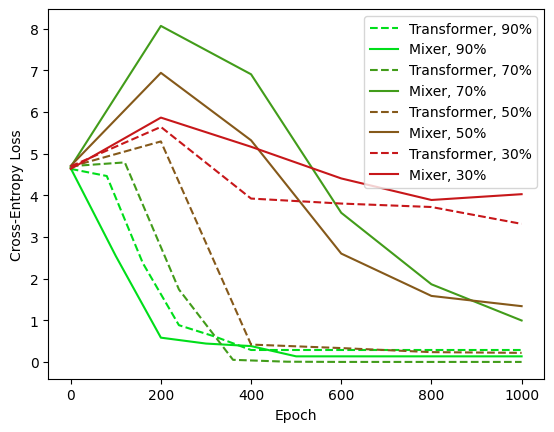

In [69]:
from matplotlib import pyplot as plt

def epochLosses_to_xy(epochLosses):
    if not any(t[0]==1000 for t in epochLosses):
        epochLosses.append((1000, epochLosses[-1][1]))
    return list(zip(*epochLosses))

fig, ax = plt.subplots()
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross-Entropy Loss")
for (train_split, transformerLosses), (train_split_, mixerLosses) in zip(transformer_test_losses, mixer_test_losses):
    transformer_xy, mixer_xy = epochLosses_to_xy(transformerLosses), epochLosses_to_xy(mixerLosses)
    ax.plot(transformer_xy[0], transformer_xy[1], label=f"Transformer, {round(train_split*100)}%",
            color=((0.9-train_split)*1.3, 1.3*train_split-0.3, 0.1), linestyle="--")
    ax.plot(mixer_xy[0], mixer_xy[1], label=f"Mixer, {round(train_split*100)}%",
            color=((0.9-train_split)*1.3, 1.3*train_split-0.3, 0.1), linestyle="-")

ax.legend()

## Section E Writeup checklist



Please compile your findings into a writeup of **two pages** plus appendices, including the following:
* figure(s) showing Transformer and MLP Mixer performance (y axis) as a function of the fraction of data used for training (x axis)
* description of the models used (encoder-only, decoder only, etc; whether you used masking in self-attention; how many layers, etc)
* description of hyperparameters, optimizers, regularisation techniques, and your method of selecting/optimizing these
* interpretation/discussion of results, any difficulties
* comparison of the merits/drawbacks of the models, both based on your findings, and in general
* appendix: stripped-down code for the dataset implementation (please remove any non-essential parts)
* appendix: stripped-down code for the transformer implementation
* appendix: stripped-down code for MLP-Mixer implementation